In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from dataset import CIFAR10C
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS


In [5]:
labels = np.load(DATA_PATHS["nfs"]["CIFAR10C"]+"labels.npy").squeeze()[:10000]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


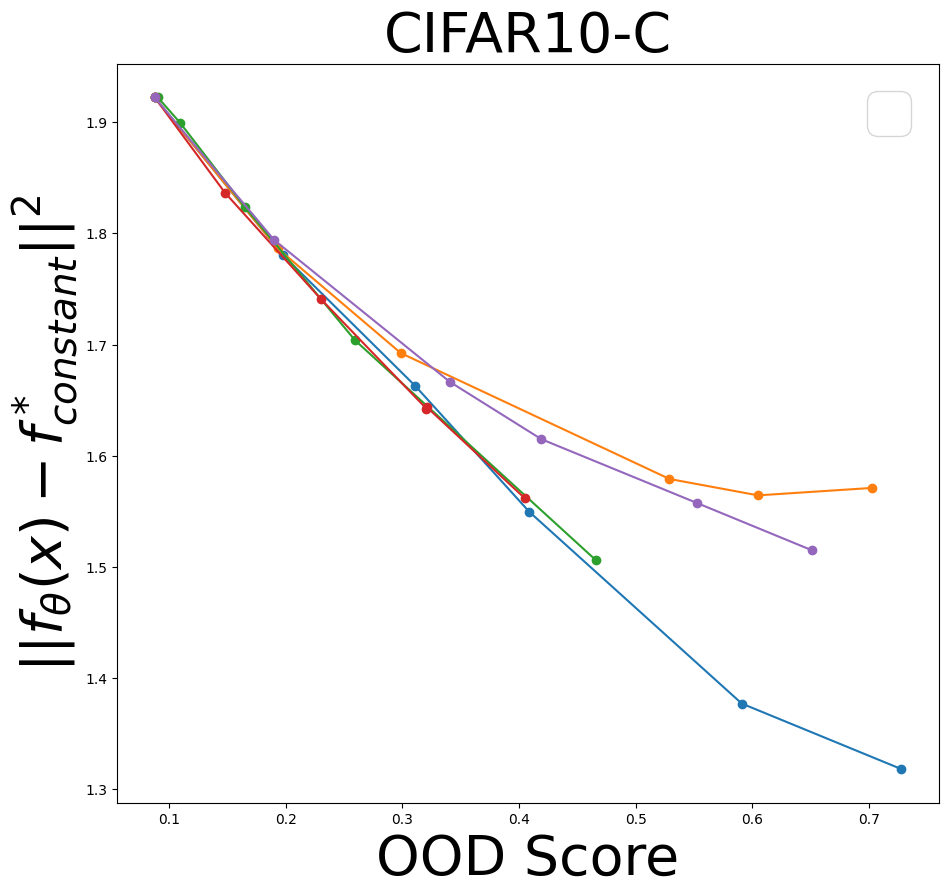

In [7]:
corruption_types = ["impulse_noise", "shot_noise", "defocus_blur", "motion_blur", "speckle_noise"]
corruption_type_labels = ["Impulse Noise", "Shot Noise", "Defocus Blur", "Motion Blur", "Speckle Noise"]

reward_prediction_run_names = ["reward_prediction_seed0_2023_05_26_19_52_05",
            "reward_prediction_seed1_2023_05_26_19_52_26",
            "reward_prediction_seed2_2023_05_26_19_52_19", 
            "reward_prediction_seed3_2023_05_26_19_52_39", 
            "reward_prediction_seed4_2023_05_26_19_53_31", 
            "reward_prediction_seed5_2023_05_26_19_53_31"]

xent_prediction_run_names = ["xent_seed0_2023_05_26_19_49_28",
                             "xent_seed1_2023_05_26_19_49_29",
                             "xent_seed2_2023_05_26_19_50_57",
                             "xent_seed3_2023_05_26_19_50_57",
                             "xent_seed4_2023_05_26_19_50_57",
                             "xent_seed5_2023_05_26_19_51_22"]

f_star = [-3.5 for _ in range(10)]
f_star.append(0)

plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()
dir_path = os.path.dirname(os.path.abspath("__file__"))

for corruption_type_idx in range(len(corruption_types)):
    corruption_type = corruption_types[corruption_type_idx]
    dist_from_f_starts_all = []
    for run_name in reward_prediction_run_names:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)

        dist_from_f_starts = []
        for corruption_level in range(6):
            dist_from_f_start = ((data[corruption_level] - np.expand_dims(f_star, axis=0))**2).mean()
            dist_from_f_starts.append(dist_from_f_start)
        dist_from_f_starts_all.append(dist_from_f_starts)

    dist_from_f_starts_all = np.array(dist_from_f_starts_all)

    accuracies_all = []
    for run_name in xent_prediction_run_names:
        with open(os.path.join(dir_path, "data", run_name, "outputs_"+corruption_type+'.pkl'), 'rb') as f:
            data = pickle.load(f)
        accuracies = []
        for corruption_level in range(6):
            accuracies.append((data[corruption_level].argmax(axis=1) == labels).mean())
        accuracies_all.append(accuracies)
    accuracies_all = np.array(accuracies_all)
    # plt.fill_between(ood_scores_all[corruption_type], dist_from_f_starts_all.mean(axis=0)-dist_from_f_starts_all.std(axis=0), dist_from_f_starts_all.mean(axis=0)+dist_from_f_starts_all.std(axis=0), alpha=0.2)
    plt.plot(1-accuracies_all.mean(axis=0), dist_from_f_starts_all.mean(axis=0), "o-")

plt.xlabel("OOD Score", fontsize=40)
plt.ylabel("$||f_{\\theta}(x) - f^*_{constant}||^2$", fontsize=40)
plt.title("CIFAR10-C", fontsize=40)

plt.legend( fontsize=40)
